# TP 2 : RL

**Il est interdit d'utiliser la fonction 'compile' de TensorFlow pour ce TP**

Source utile : https://arxiv.org/pdf/1312.5602.pdf

Le but de ce TP sera de découvrir et mettre en place un algorithme d'apprentissage par renforcement profond : le DQN.
Vous apprendrez à un agent à jouer au jeu du cartpole, qui consiste à déplacer une plateforme sur laquelle est posé un baton de manière à ce que le baton reste en équilibre sur la plateforme.

Nous allons utiliser la librairie TensorFlow et faire tourner notre code sous Google Colab pour nos TP, ce qui aura l'avantage de nous permettre d'utiliser les GPUs mis à disposition gratuitement par Google.
Vous êtes libre d'utiliser une autre librairie que TensorFlow si vous en maîtrisez une autre ou votre machine personnelle si celle-ci possède un GPU suffisant, mais il est probable que les phases d'entraînement soit plus rapides sous Colab.

N'hésitez pas à vous référer aux docs de TensorFlow 2 et Keras disponibles sur internet lors de ce TP.

Ce TP s'effectue individuellement ou en binome. Veuillez respecter les consignes suivantes pour le rendu de votre travail :

*   Renommez le selon le format suivant : "DL_2023_TP_RL_prenom1_nom1_prenom2_nom2.ipynb".
*   Veillez à ce que votre nom et prénom soient complétés dans la cellule ci-dessous.
*   Veillez à avoir bien exécuté toutes les cellules de code et que les résultats soient tous bien visible dans le notebook sans nécessiter une ré-exécution.
*   Partagez le notebook avec ranvier.thomas.pro@gmail.com.

Si vous avez effectué le TP autrement que sur Google Colab :

*   Renommez le selon le format suivant : "DL_2023_TP_RL_prenom1_nom1_prenom2_nom2.ipynb".
*   Téléchargez le fichier ipynb.
*   Envoyez le fichier en pièce-jointe à ranvier.thomas.pro@gmail.com, en indiquant en tant qu'objet : "TP RL prenom1 nom1 prenom2 nom2".

---

## Veuillez compléter vos noms et prénoms ci-dessous :

*   **Prenom 1** : Yann
*   **Nom 1** : VINCENT
*   **Prenom 2** : Kevin
*   **Nom 2** : TANG

In [ ]:
%%capture
import tensorflow as tf
import gym
from gym.wrappers.record_video import RecordVideo
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from base64 import b64encode
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---
# Visualisation d'un épisode de Cartpole

Vous allez utiliser l'environement cartpole proposé par la librairie gym. A chaque étape l'environement nous envoie une observation correspondant à l'état actuel de l'environement et on doit envoyer une action (0 ou 1 pour gauche ou droite) en réponse.

Commencez par visualiser un épisode en ne sélectionnant que des actions aléatoires.

In [ ]:
# Environment initialization
env = gym.make('CartPole-v1')
# Put the environment in a wrapper to save the episode video
env = RecordVideo(env, './example')

# Start a new episode and get the first environment state
state = env.reset()
done = False
# While the episode is not over
while not done:
    # Select a random action
    action_index = random.randrange(env.action_space.n)
    # Execute selected action in the environment and get new observation and reward
    next_state, reward, done, _ = env.step(action_index)

env.close()

In [ ]:
state

array([ 0.02939191,  0.03054197, -0.02574031, -0.00196897], dtype=float32)

In [ ]:
def viz_episode(filename):
    mp4 = open('./example/' + filename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

# Play the episode video
viz_episode('rl-video-episode-0.mp4')

---
# Déclaration des hyperparamètres

Le but de ce TP n'étant pas de chercher les meilleurs hyperparamètres possibles vous trouverez ci-dessous l'initilisation d'hyperparamètres par défaut qui donnent de bons résultats.

In [ ]:
# Reinitialize environment
env = gym.make('CartPole-v1')

# Get environment observation size and number of possible actions
obs_size = env.observation_space.shape[0]
nb_actions = env.action_space.n

#Hyper Parameters
training_episodes = 200                     # Max number of training episodes
gamma = .95                                 # Discount factor used in Q-function
learning_rate = .001                        # Learning rate of the optimizer
batch_size = 24
epsilon_max = 1.                            # Maximum epsilon value at 1.
epsilon_min = .05                           # Minimum epsilon value at .05
epsilon_decay = .995                        # Epsilon decay factor at .995
replay_memory_capacity = 2500               # Limit memory capacity at 2500
print_step = 10                             # Print recap every 10 steps
target_avg_reward = 300                     # Early stop if avg reward >= 200

---
# Création de la replay memory

La replay memory est utilisée pour stocker les transitions entre l'agent et l'environement. Chaque transition stockée est composée de l'état de départ, l'action réalisée par l'agent, l'état d'arrivée, le reward obtenu et si l'état d'arrivée est terminal ou non.

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self._capacity = capacity
        self._memory = []
        self._position = 0

    def push(self, state, next_state, action, reward, done):
        """
        Cette méthode doit permettre de stocker une transition dans la mémoire
        tout en s'assurant que le nombre d'transitions stockée ne dépasse pas
        sa capacité.
        Si c'est le cas la nouvelle transition doit écraser la plus ancienne.

        Une transition contient :
            - state: np.array, l'état de départ
            - next_state: np.array, l'état d'arrivée
            - action: tf.tensor, l'action effectuée. Dans un soucis d'efficience
                      vous devez stocker l'action directement sous forme de
                      one-hot tensor, obtenu avec : action = tf.one_hot(action_index, nb_actions)
            - reward: int, le reward obtenu grâce à l'action effectuée
            - done: boolean, indique si le baton est tombé ou non
        """
        action_index = np.argmax(action.numpy())  # Obtenez l'indice de l'action à partir du one-hot tensor
        action_one_hot = tf.one_hot(action_index, nb_actions)

        transition = (state, next_state, action_one_hot, reward, done)

        if len(self._memory) < self._capacity:
            self._memory.append(transition)
        else:
            self._memory[self._position] = transition
            self._position = (self._position + 1) % self._capacity

    def sample(self, batch_size):
        """
        Cette méthode doit extraire une minibatch de la taille voulue de la
        mémoire de manière aléatoire. Elle prend en entrée la taille de la batch
        à extraire.

        La méthode doit retourner :
            - state_s: np.array, contenant les états de départ
            - state_next_s: np.array, contenant les états d'arrivées
            - action_s: tf.tensor, contenant les one-hots vectors des actions
            - rewards_s: tf.tensor, contenant les rewards
            - opp_done_s: tf.tensor, contenant l'opposé du flag 'done' converti en float
        """
        # Sélection aléatoire des indices de la mémoire
        indices = random.sample(range(len(self._memory)), batch_size)

        # Initialisation des listes pour stocker les données de la minibatch
        state_s, state_next_s, action_s, rewards_s, opp_done_s = [], [], [], [], []

        # Extraction des données de la mémoire pour chaque indice sélectionné
        for index in indices:
            state, next_state, action, reward, done = self._memory[index]

            # Ajout des données dans les listes
            state_s.append(state)
            state_next_s.append(next_state)
            action_s.append(action)
            rewards_s.append(reward)
            opp_done_s.append(1.0 - float(done))

        # Conversion des listes en numpy arrays et tensors TensorFlow
        state_s = np.array(state_s)
        state_next_s = np.array(state_next_s)
        action_s = tf.convert_to_tensor(action_s)
        rewards_s = tf.convert_to_tensor(rewards_s, dtype=tf.float32)
        opp_done_s = tf.convert_to_tensor(opp_done_s, dtype=tf.float32)

        return state_s, state_next_s, action_s, rewards_s, opp_done_s


    def __len__(self):
        """
        Cette méthode override les appels de length sur l'objet ReplayMemory.
        Elle doit retourner la quantité actuelle de transitions sauvegardées
        dans la mémoire.
        """
        return len(self._memory)

---
# Création de l'agent

L'agent apprend à intéragir et executer ses actions avec l'environnement.

In [ ]:
class Agent():
    def __init__(self, replay_memory, model, optimizer, loss_function, env):
        self._rm = replay_memory
        self._epsilon = epsilon_max
        self._model = model
        self._optimizer = optimizer
        self._loss_function = loss_function
        self._env = env
        # History
        self._reward_hist = []

    def train(self):
        """
        Méthode principale, lance l'entraînement de l'agent.
        """
        start = time.time()
        avg_reward = 0
        for episode in range(training_episodes):
            # Run 1 episode
            episode_reward = self._run_episode()
            self._reward_hist.append(episode_reward)
            avg_reward += episode_reward
            if (episode + 1) % print_step == 0:
                print(f'episode: {episode + 1}/{training_episodes}, avg reward: {avg_reward / print_step}, e: {self._epsilon}')
                # Early stop
                if avg_reward / print_step >= target_avg_reward:
                    break
                avg_reward = 0
        print(f'training done in {time.time() - start:.2f}s')
        self._plot_history()

    def _run_episode(self):
        """
        Cette méthode doit exécuter un épisode d'apprentissage.
        """
        # Initialize environment and get first state
        state = self._env.reset()

        episode_reward = 0
        done = False
        while not done:
            # Select an action, randomly in epsilon % of the time, and using
            # the model output otherwise.
            if np.random.rand() < self._epsilon:
                action_index = np.random.choice(self._env.action_space.n)
            else:
                state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
                state_tensor = tf.expand_dims(state_tensor, axis=0)
                q_values = self._model(state_tensor)
                action_index = tf.argmax(q_values[0]).numpy()

            # Perform selected action in the environment, get next state, reward
            # and done status
            next_state, reward, done, _ = self._env.step(action_index)

            # Convert the next state to np.array type
            next_state = np.array(next_state, dtype=np.float32)

            # Update episode total reward
            # Ajouter la logique de récompense en fonction de l'éloignement du centre ici
            position = next_state[0]  # Assuming the position information is in the first element
            # Récupérer l'angle depuis le state
            angle = next_state[2]  # Modifier cela en fonction de la position de l'angle dans le state

            # Calculer la récompense en fonction de la distance et de l'angle


            reward_for_distance = 1 / (1 + abs(position))  # Ajustez cette formule si nécessaire
            episode_reward += reward_for_distance


            # Convert the selected action index to a one-hot tensor for
            # efficiency (cf. tf.one_hot())
            action_one_hot = tf.one_hot(action_index, self._env.action_space.n)

            # Add observation to the replay memory
            self._rm.push(state, next_state, action_one_hot, reward, done)

            # Replace current state with next state
            state = next_state

            # If there are enough transitions in the replay memory:
            if len(self._rm) >= batch_size:
                # extract a minibatch from the memory
                state_batch, next_state_batch, action_batch, reward_batch, opp_done_batch = self._rm.sample(batch_size)

                # call the optimize function to train the model on the minibatch
                self._optimize(state_batch, next_state_batch, action_batch, reward_batch, opp_done_batch)

                # update epsilon
                self._epsilon = max(epsilon_min, self._epsilon * epsilon_decay)

        return episode_reward


    @tf.function
    def _optimize(self, state_s, state_next_s, action_s, rewards_s, opp_done_s):
        """
        Cette méthode calcule la Q-loss, elle doit ensuite faire la
        backpropagation.
        """
        # Q-loss
        q_values_target = self._model(state_next_s)
        q_values_target = rewards_s + (gamma * tf.reduce_max(q_values_target, axis=1)) * opp_done_s
        with tf.GradientTape() as tape:
            q_values_pred = self._model(state_s)
            q_values_pred = tf.reduce_sum(tf.multiply(q_values_pred, action_s), axis=1)
            loss = self._loss_function(q_values_target, q_values_pred)
        # Backpropagation (compute gradients and apply gradients using tf functions)
        gradients = tape.gradient(loss, self._model.trainable_variables)
        self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))


    def _plot_history(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self._reward_hist)
        plt.xlabel('episodes')
        plt.ylabel('reward')
        plt.title('Reward per episode')
        plt.show()

    def real_episode(self, env):
        state = env.reset()
        done = False
        while not done:
            output = self._model(np.expand_dims(state, axis=0))
            action_index = np.argmax(output.numpy())
            state, _, done, _ = env.step(action_index)

---
# Entraînement de l'agent

Si tout est correct vous devriez voir la récompense moyenne des 10 derniers épisodes d'apprentissage commencer à augmenter entre 50 et 100 épisodes.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define a fully-connected model
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(obs_size,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(nb_actions, activation='linear')  # Assuming nb_actions is the number of output actions
])

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.MeanSquaredError()

# Other hyperparameters
replay_memory_capacity = 2500
# ...

# Create the replay memory
replay_memory = ReplayMemory(replay_memory_capacity)

# Create the agent
agent = Agent(replay_memory, model, optimizer, loss_function, env)


episode: 10/200, avg reward: 16.674950668991812, e: 0.4598090507939749
episode: 20/200, avg reward: 10.172172840430935, e: 0.26759021970270175
episode: 30/200, avg reward: 10.018734796828983, e: 0.1572956799768517
episode: 40/200, avg reward: 11.30206419345348, e: 0.08662902049662846
episode: 50/200, avg reward: 18.63880735720187, e: 0.05
episode: 60/200, avg reward: 63.69147199130911, e: 0.05
episode: 70/200, avg reward: 83.82048285225576, e: 0.05
episode: 80/200, avg reward: 80.18813419666103, e: 0.05
episode: 90/200, avg reward: 121.96039721270589, e: 0.05
episode: 100/200, avg reward: 168.80892200756892, e: 0.05
episode: 110/200, avg reward: 54.905774149366565, e: 0.05
episode: 120/200, avg reward: 226.55372143209902, e: 0.05
episode: 130/200, avg reward: 329.6000999869488, e: 0.05
training done in 118.25s


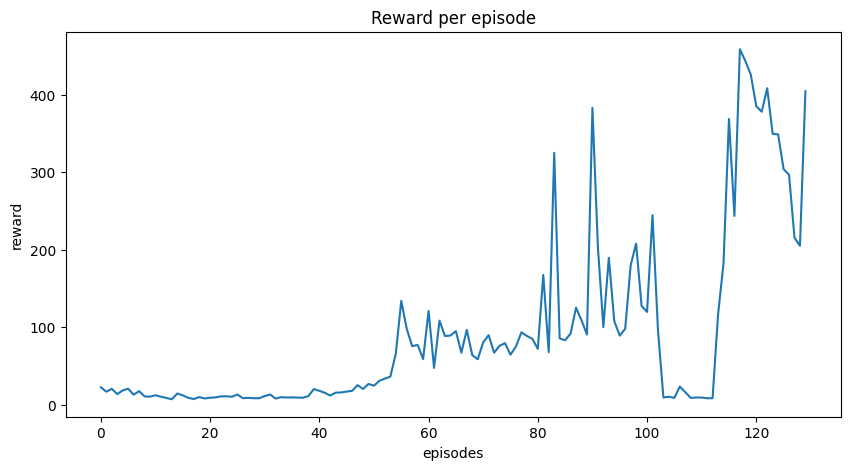

In [ ]:
# Training
agent.train()

In [ ]:
# Run a test episode
env = gym.make('CartPole-v1')
env = RecordVideo(env, './episode')
agent.real_episode(env)
env.close()

In [ ]:
# Visualize the test episode
viz_episode('../episode/rl-video-episode-0.mp4')